In [4]:
# gpu number setting
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = '1' ## gpu 번호 셋팅 윤건 :0, 기준 : 1, 준형 :2,

# Gpu growth setting
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)


# tensorflow & keras version check
print('tensorflow version : ' , tf.__version__)
print('keras version : ' , tf.keras.__version__)

# tensorflow gpu available check 
print('GPU available ? : ', tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))

tensorflow version :  2.3.1
keras version :  2.4.0
GPU available ? :  True


In [5]:
import pandas as pd
import numpy as np
import pickle
import tqdm
import random
import time

from sklearn.metrics import log_loss, roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from deepctr.models import *
from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names

In [6]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [7]:
with open('../../Data/movie_201118_table_6_10.pickle', 'rb') as f:
    data = pickle.load(f)

In [8]:
sparse_features = ['sa_id', 'album_id', 'buy_seg']
dense_features = ['release_date', 'run_time', 'movie_meta_price', 'i30_meta_price', 'buy_tot',
                  'amt_1_4', 'amt_2_4', 'amt_3_4', 'amt_4_4']
target = ['label']

In [9]:
lbe_dict = {}
for feat in sparse_features:
    lbe = LabelEncoder()
    lbe.fit(data[feat])
    data[feat] = lbe.transform(data[feat])
    lbe_dict[feat] = lbe
    
mms = MinMaxScaler(feature_range=(0, 1))
data[dense_features] = mms.fit_transform(data[dense_features])

In [10]:
fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].nunique(),embedding_dim=4)
                           for i,feat in enumerate(sparse_features)]

dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

* separate positive and negative 

In [14]:
pos = data[data['label'] == 1]

In [15]:
neg = data[data['label'] != 1]

In [20]:
neg_sample = neg.sample(frac=0.5)

In [22]:
final_input = pd.concat([pos, neg_sample])

In [24]:
train, test = train_test_split(final_input, test_size=0.2, random_state=2020)
train_model_input = {name:train[name] for name in feature_names}
test_model_input = {name:test[name] for name in feature_names}

In [25]:
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='binary')
model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

In [26]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [27]:
history = model.fit(train_model_input, train[target].values,
                    batch_size=2**18, epochs=200, verbose=1, validation_split=0.2,
                   callbacks=[callback])

Epoch 1/200


/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


115/115 [==============================] - 4s 38ms/step - loss: 0.3683 - binary_crossentropy: 0.3665 - val_loss: 0.2247 - val_binary_crossentropy: 0.2217
Epoch 2/200
115/115 [==============================] - 4s 34ms/step - loss: 0.2199 - binary_crossentropy: 0.2158 - val_loss: 0.2153 - val_binary_crossentropy: 0.2106
Epoch 3/200
115/115 [==============================] - 4s 34ms/step - loss: 0.2108 - binary_crossentropy: 0.2041 - val_loss: 0.2112 - val_binary_crossentropy: 0.2033
Epoch 4/200
115/115 [==============================] - 4s 34ms/step - loss: 0.2004 - binary_crossentropy: 0.1914 - val_loss: 0.2074 - val_binary_crossentropy: 0.1978
Epoch 5/200
115/115 [==============================] - 4s 34ms/step - loss: 0.1925 - binary_crossentropy: 0.1824 - val_loss: 0.2062 - val_binary_crossentropy: 0.1958
Epoch 6/200
115/115 [==============================] - 4s 34ms/step - loss: 0.1867 - binary_crossentropy: 0.1758 - val_loss: 0.2054 - val_binary_crossentropy: 0.1944
Epoch 7/200
115/

In [28]:
pred_ans = model.predict(test_model_input, batch_size=2**16)
print("test LogLoss", round(log_loss(test[target].values, pred_ans), 4))
print("test AUC", round(roc_auc_score(test[target].values, pred_ans), 4))

test LogLoss 0.1938
test AUC 0.956


In [29]:
from sklearn.metrics import classification_report, confusion_matrix

In [30]:
y_pred = pred_ans.round()

In [31]:
conf = confusion_matrix(test[target], y_pred)
print(conf)

[[7431794  353287]
 [ 394770 1163511]]


In [32]:
report = classification_report(test[target], y_pred, target_names=['0', '1'])
report_dict = classification_report(test[target], y_pred, target_names=['0', '1'], output_dict = True)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95   7785081
           1       0.77      0.75      0.76   1558281

    accuracy                           0.92   9343362
   macro avg       0.86      0.85      0.85   9343362
weighted avg       0.92      0.92      0.92   9343362



In [62]:
lbe_dict['sa_id'].transform(['500150964610'])

array([700773])

In [65]:
user_col = ['sa_id', 'buy_seg', 'buy_tot']
cont_col = ['album_id', 'release_date', 'run_time', 'movie_meta_price', 'i30_meta_price',
                'amt_1_4', 'amt_2_4', 'amt_3_4', 'amt_4_4'] + [str(i) for i in range(33)]

In [68]:
print(len(data.columns))
print(len(user_col))
print(len(cont_col))

46
3
42


In [69]:
user_tab = data[user_col]
cont_tab = data[cont_col]

In [71]:
user_uni_tab = user_tab.loc[list(user_tab['sa_id'].drop_duplicates().index)]
cont_uni_tab = cont_tab.loc[list(cont_tab['album_id'].drop_duplicates().index)]

In [74]:
user_uni_tab[user_uni_tab['sa_id'] == 700773]

,sa_id,buy_seg,buy_tot
1551439,700773,0,0.004425


In [76]:
test_tab = cont_uni_tab.copy()

In [98]:
for feat in user_col:
    test_tab[feat] = user_uni_tab[user_uni_tab['sa_id'] == 700773][feat].values[0]

In [104]:
f_test_model_input = {name:test_tab[name] for name in feature_names}

In [99]:
test_tab

,album_id,release_date,run_time,movie_meta_price,i30_meta_price,amt_1_4,amt_2_4,amt_3_4,amt_4_4,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,sa_id,buy_seg,buy_tot
0,10985,0.999532,0.305040,0.202041,0.202041,1.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,700773,0,0.004425
9501,10864,0.929161,0.270557,0.000000,0.000000,1.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,700773,0,0.004425
10587,2754,0.823270,0.225464,0.028571,0.028571,1.0,0.0,0.0,0.0,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,700773,0,0.004425
19189,4959,0.952780,0.251989,0.051020,0.051020,0.0,1.0,0.0,0.0,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,700773,0,0.004425
20105,10971,0.893068,0.251989,0.028571,0.028571,1.0,0.0,0.0,0.0,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,700773,0,0.004425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15568849,6494,0.975435,0.294430,0.028571,0.028571,1.0,0.0,0.0,0.0,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,700773,0,0.004425
15569531,2918,0.647475,0.259947,0.051020,0.051020,1.0,0.0,0.0,0.0,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,700773,0,0.004425
15570236,4950,0.952992,0.323607,0.071429,0.071429,1.0,0.0,0.0,0.0,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,700773,0,0.004425
15570932,4146,0.952078,0.222812,0.051020,0.028571,0.0,0.0,0.0,1.0,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,700773,0,0.004425


In [106]:
test_pred = model.predict(f_test_model_input, batch_size=2**16)

In [107]:
test_pred.argsort()

array([[0.914798  ],
       [0.5746706 ],
       [0.3489188 ],
       ...,
       [0.22076014],
       [0.03571917],
       [0.57717866]], dtype=float32)

In [112]:
np.reshape(test_pred, (-1))

array([0.914798  , 0.5746706 , 0.3489188 , ..., 0.22076014, 0.03571917,
       0.57717866], dtype=float32)

In [121]:
top10_idx = np.reshape(test_pred, (-1)).argsort()[-10:]

In [124]:
top10_idx

array([296, 577, 399, 342,  36, 293, 144,  38,  64,  56])

In [127]:
test_pred[56]

array([0.96092564], dtype=float32)

In [132]:
top10_album_idx = test_tab.iloc[top10_idx]['album_id'].values

In [133]:
top10_album_idx

array([11502, 10984, 11668, 11463, 11559, 11337, 11049, 11529, 11207,
       11175])

In [140]:
album_list = lbe_dict['album_id'].inverse_transform(top10_album_idx)

In [145]:
tmp = pd.read_csv('../../Data/movie_201118.csv')

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,26,27,28,29,37,39) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [146]:
tmp

,sa_id,s_time,e_time,watch_duration,album_id,album_name,gubun,vod_s_point,vod_e_point,agree_yn,category_id,release_date,run_time,meta_genre,genre_large,genre_mid,genre_small,movie_meta_price,buy_history_price,i30_meta_price,buy_tot,view_no,fod,buy_1_2,buy_3,buy_seg,amt_1_4,amt_2_4,amt_3_4,amt_4_4,amt_r_gabun,weekdays,weekends,dawn,morning,afternoon,evening,watch_ratio,current_rate,ncf_rating
0,205101491713,20200826090744,2.020083e+13,6676.0,M01208D595PPV00,반도(소장),WT,40.0,6716.0,Y,NaN,20200715.0,115,액션,영화,액션,NaN,9900.0,\N,9900,0,1,0,0,0,VIEW_NO,1,0,0,0,AMT_0_R,1,0,0,1,0,0,0.967536231884058,0.461111,0.7532125603864734
1,205101521683,20200827211322,NaN,\N,M011526134PPV00,[우리말]마다가스카,W,NaN,NaN,Y,NaN,20050714.0,85,극장판 애니,영화,극장판 애니,어린이/가족,1400.0,\N,1400,0,0,1,0,0,FOD,1,0,0,0,AMT_0_R,1,0,0,0,0,1,0.8,0.455556,0.6722222222222223
2,205101521683,20201001155631,2.020100e+13,5193.0,M01208A459PPV00,[우리말]메가마인드,WT,25.0,5218.0,Y,NaN,20110113.0,95,극장판 애니,영화,극장판 애니,어린이/가족,1400.0,\N,1400,0,0,1,0,0,FOD,1,0,0,0,AMT_0_R,1,0,0,0,1,0,0.9110526315789473,0.261111,0.8249707602339181
3,205101521683,20201103103535,2.020110e+13,6293.0,M01188R075PPV00,기문둔갑,WT,33.0,6326.0,Y,NaN,20171215.0,112,액션,영화,액션,NaN,1400.0,\N,1400,0,0,1,0,0,FOD,1,0,0,0,AMT_0_R,1,0,0,1,0,0,0.9364583333333333,0.077778,0.9293402777777777
4,205101521683,20200925212911,2.020093e+13,110.0,M01133TA30PPV00,가디언즈,WT,140.0,250.0,Y,NaN,20121129.0,97,극장판 애니,영화,극장판 애니,어린이/가족,1400.0,\N,1400,0,0,1,0,0,FOD,1,0,0,0,AMT_0_R,1,0,0,0,0,1,0.018900343642611683,0.294444,0.3622279495990836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8459359,M18061900001,20200909211937,NaN,\N,M012054529PPV00,[우리말]마다가스카 3: 이번엔 서커스다!(소장),W,NaN,NaN,Y,AL093,20120606.0,94,극장판 애니,영화,극장판 애니,어린이/가족,13900.0,\N,13900,8,0,0,0,1,BUY_3,0.0,0.375,0.0,0.625,AMT_5000_OVER_R,1,0,0,0,0,1,0.8,0.383333,0.708333
8459360,M18061900001,20200922130942,2.020092e+13,30.0,M01204M075PPV00,양자물리학,WT,338.0,368.0,Y,NaN,20190925.0,120,스릴러,영화,스릴러,NaN,3500.0,3500,3500,8,0,0,0,1,BUY_3,0.0,0.375,0.0,0.625,AMT_5000_OVER_R,1,0,0,0,1,0,0.00416667,0.311111,0.346528
8459361,M18061900001,20201001230620,2.020100e+13,6116.0,M01206U082PPV00,나의 첫 번째 슈퍼스타(소장),WT,677.0,6793.0,Y,NaN,20200610.0,113,코미디,영화,코미디,NaN,7700.0,9900,7700,8,0,0,0,1,BUY_3,0.0,0.375,0.0,0.625,AMT_5000_OVER_R,1,0,0,0,0,1,0.902065,0.261111,0.820477
8459362,M18061900001,20201001230620,2.020100e+13,6116.0,M01206U082PPV00,나의 첫 번째 슈퍼스타(소장),WT,-6116.0,0.0,Y,NaN,20200610.0,113,코미디,영화,코미디,NaN,7700.0,9900,7700,8,0,0,0,1,BUY_3,0.0,0.375,0.0,0.625,AMT_5000_OVER_R,1,0,0,0,0,1,0.902065,0.261111,0.820477


In [149]:
title = []

for album in album_list:
    title.append(tmp[tmp['album_id'] == album]['album_name'].values[0])

In [150]:
title

['기기괴괴 성형수',
 '강철비2: 정상회담',
 '검객(2020)',
 '아웃포스트(2020)',
 '담보',
 '에이바',
 '반도',
 '국제수사',
 '오케이 마담',
 '다만 악에서 구하소서']

In [14]:
import matplotlib.pyplot as plt

(array([1162466.,  107607.,   77436.,   69661.,   71367.,   80663.,
         100856.,  139672.,  236865., 1067861.]),
 array([4.7636490e-06, 1.0000041e-01, 1.9999607e-01, 2.9999170e-01,
        3.9998737e-01, 4.9998301e-01, 5.9997869e-01, 6.9997430e-01,
        7.9996997e-01, 8.9996558e-01, 9.9996126e-01], dtype=float32),
 <a list of 10 Patch objects>)

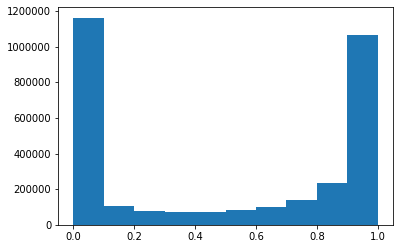

In [15]:
plt.hist(pred_ans)

In [16]:
model.save(filepath='./model/201120/')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./model/201120/assets
